In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import csv

In [2]:
# 0) Robot Parameters
L1, L2, L3 = 30.0, 15.0, 10.0

In [3]:
# 1) Forward Kinematics (deg input for dataset)
def forward_kinematics_deg(t1_deg, t2_deg, t3_deg):
    t1 = np.radians(t1_deg)
    t2 = np.radians(t2_deg)
    t3 = np.radians(t3_deg)

    t12  = t1 + t2
    t123 = t12 + t3

    x1 = L1 * np.cos(t1)
    y1 = L1 * np.sin(t1)

    x2 = x1 + L2 * np.cos(t12)
    y2 = y1 + L2 * np.sin(t12)

    x3 = x2 + L3 * np.cos(t123)
    y3 = y2 + L3 * np.sin(t123)

    phi_deg = t1_deg + t2_deg + t3_deg  
    return x3, y3, phi_deg

In [4]:
# 2) Dataset Generation (FK-based, multi-solution 미고려)
def generate_random_dataset(filename, N=100000):
    theta1 = np.random.uniform(0, 180, N)
    theta2 = np.random.uniform(-180, 0, N)   # θ2 < 0 (elbow-down)
    theta3 = np.random.uniform(-180, 180, N)

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["theta1_deg", "theta2_deg", "theta3_deg",
                         "x", "y", "theta_global_deg"])

        for t1, t2, t3 in zip(theta1, theta2, theta3):
            x, y, phi = forward_kinematics_deg(t1, t2, t3)
            writer.writerow([t1, t2, t3, x, y, phi])

    print("CSV saved:", filename)


generate_random_dataset("robot_ik_elbowdown.csv", 100000)

CSV saved: robot_ik_elbowdown.csv


In [5]:
# 3) Load Dataset
def load_dataset(filename):
    xs, ys, phis = [], [], []
    t1s, t2s, t3s = [], [], []

    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # 첫번째 줄 스킵 
        for row in reader:
            t1 = float(row[0])
            t2 = float(row[1])
            t3 = float(row[2])
            x  = float(row[3])
            y  = float(row[4])
            phi = float(row[5])
            xs.append(x)
            ys.append(y)
            phis.append(phi)
            t1s.append(t1)
            t2s.append(t2)
            t3s.append(t3)

    X = np.column_stack([xs, ys, phis])   # (x, y, phi_deg)
    Y = np.column_stack([t1s, t2s, t3s])  # (theta1, theta2, theta3) deg
    return X, Y

X_raw, Y_raw = load_dataset("robot_ik_elbowdown.csv")

In [6]:
# 4) Normalization
X_max = np.array([55.0, 55.0, 1080.0])
Y_max = np.array([180.0, 360.0, 360.0])

X_norm = X_raw / X_max
Y_norm = Y_raw / Y_max

X = torch.tensor(X_norm, dtype=torch.float32)
Y = torch.tensor(Y_norm, dtype=torch.float32)

In [7]:
# 5) Train/Val/Test Split (70 / 15 / 15)
N = len(X)
idx_train = int(N * 0.70)
idx_val   = int(N * 0.85)

X_train, Y_train = X[:idx_train], Y[:idx_train]
X_val,   Y_val   = X[idx_train:idx_val], Y[idx_train:idx_val]
X_test,  Y_test  = X[idx_val:], Y[idx_val:]

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=256, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=256, shuffle=False)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 70000 Val: 15000 Test: 15000


In [8]:
# 6) Deep MLP Model
class DeepIK(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
    def forward(self, x):
        return self.net(x)

model = DeepIK()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
lambda_periodic = 0.1  # angle-periodicity term scaling

In [9]:
# 7) Periodicity-aware Loss
def periodic_loss(pred_norm, gt_norm):
    """Compute periodicity-aware loss for angle"""
    # Unnormalize to degrees
    scales = torch.tensor([180.0, 360.0, 360.0])
    pred_deg = pred_norm * scales
    gt_deg   = gt_norm   * scales
    
    # convert to radians
    pred_rad = pred_deg * np.pi/180.0
    gt_rad   = gt_deg   * np.pi/180.0

    diff = pred_rad - gt_rad
    return torch.mean(1.0 - torch.cos(diff))

Epoch   1 | Train Loss: 8.084704 | Val Loss: 0.144442
Epoch   2 | Train Loss: 0.426918 | Val Loss: 0.060028
Epoch   3 | Train Loss: 0.242678 | Val Loss: 0.049976
Epoch   4 | Train Loss: 0.186570 | Val Loss: 0.047944
Epoch   5 | Train Loss: 0.152318 | Val Loss: 0.027607
Epoch   6 | Train Loss: 0.129610 | Val Loss: 0.023881
Epoch   7 | Train Loss: 0.112605 | Val Loss: 0.020385
Epoch   8 | Train Loss: 0.110108 | Val Loss: 0.022237
Epoch   9 | Train Loss: 0.092691 | Val Loss: 0.021614
Epoch  10 | Train Loss: 0.088402 | Val Loss: 0.015583
Epoch  11 | Train Loss: 0.080561 | Val Loss: 0.016513
Epoch  12 | Train Loss: 0.076320 | Val Loss: 0.014919
Epoch  13 | Train Loss: 0.071825 | Val Loss: 0.018275
Epoch  14 | Train Loss: 0.066426 | Val Loss: 0.011318
Epoch  15 | Train Loss: 0.074721 | Val Loss: 0.015298
Epoch  16 | Train Loss: 0.063098 | Val Loss: 0.013798
Epoch  17 | Train Loss: 0.061319 | Val Loss: 0.009973
Epoch  18 | Train Loss: 0.061969 | Val Loss: 0.011415
Epoch  19 | Train Loss: 0.05

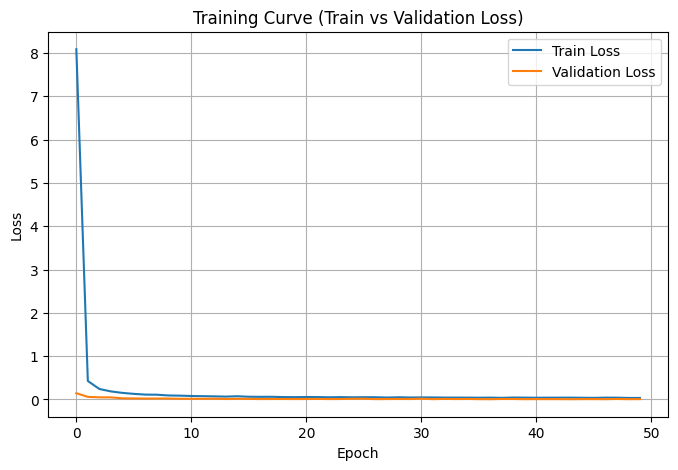

In [10]:
# 8) Training Loop (Train + Validation)
epochs = 50
train_losses = []
val_losses = []

for ep in range(epochs):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)

        loss_mse = mse_loss(pred, yb)
        loss_p   = periodic_loss(pred, yb)
        loss = loss_mse + lambda_periodic * loss_p

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss_mse = mse_loss(pred, yb)
            loss_p   = periodic_loss(pred, yb)
            val_loss += (loss_mse + lambda_periodic * loss_p).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {ep+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


# TRAINING RESULT PLOT 
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve (Train vs Validation Loss)")
plt.grid(True)
plt.legend()
plt.show()


=== 몇 개 샘플 (GT vs Pred) ===
Sample 1
  GT   (deg): [  13.56164977  -56.44884825 -126.00064158]
  Pred (deg): [  13.01770046  -57.34482944 -126.05505824]
Sample 2
  GT   (deg): [  83.49745631 -115.30579448  141.03965878]
  Pred (deg): [  82.70733118 -111.98766589  137.67073989]
Sample 3
  GT   (deg): [  73.42580974 -109.85982656   38.75236005]
  Pred (deg): [  73.4736979  -110.37231088   38.58365715]
Sample 4
  GT   (deg): [ 110.82680583 -152.09332108 -132.85682917]
  Pred (deg): [ 109.86852765 -152.72026062 -133.30798745]
Sample 5
  GT   (deg): [ 19.83953834  -3.48982684 129.39336777]
  Pred (deg): [ 21.36848062  -6.90087721 130.90252876]


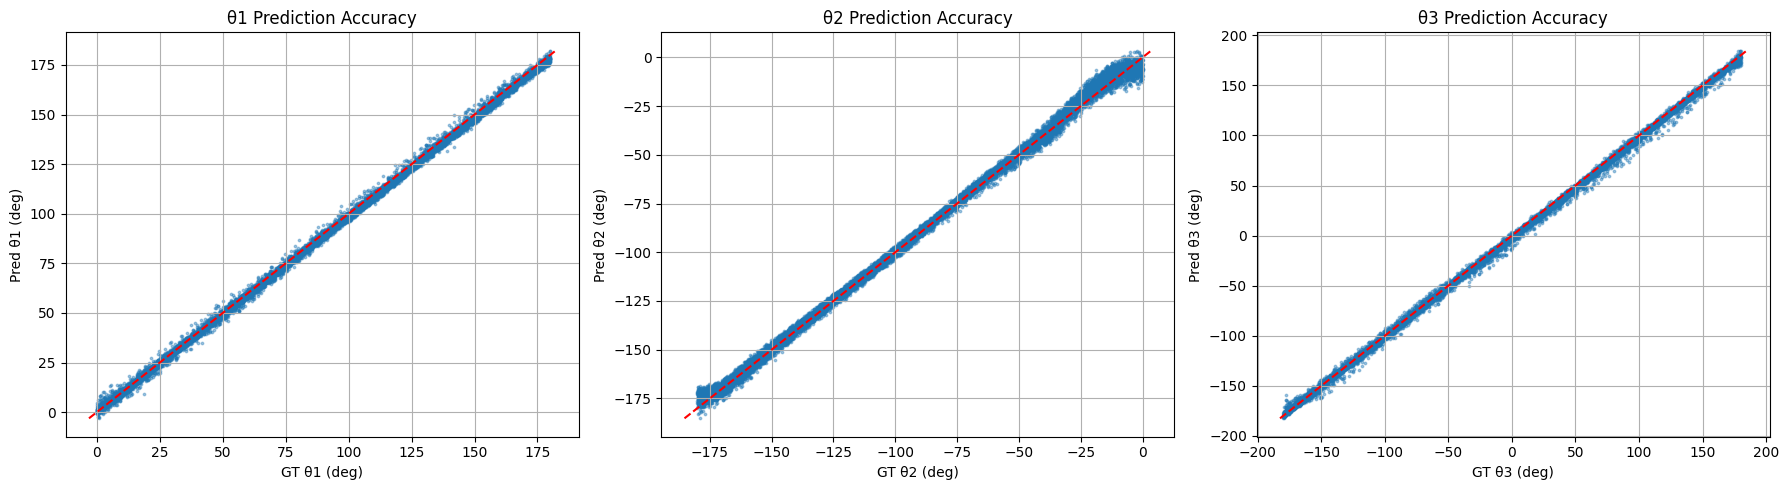


=== Test Dataset Error (Joint-wise) ===
θ1 | MAE: 1.292 deg | RMSE: 1.622 deg
θ2 | MAE: 1.970 deg | RMSE: 2.599 deg
θ3 | MAE: 1.903 deg | RMSE: 2.689 deg


In [11]:
# 9) Test Set Evaluation — 전체 GT vs Pred 비교
model.eval()
all_gt_deg = []
all_pred_deg = []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        # denormalize
        gt_deg  = yb.numpy()   * Y_max
        pd_deg  = pred.numpy() * Y_max

        all_gt_deg.append(gt_deg)
        all_pred_deg.append(pd_deg)

all_gt_deg   = np.vstack(all_gt_deg)
all_pred_deg = np.vstack(all_pred_deg)

# 랜덤 몇 개 샘플 출력
print("\n=== 몇 개 샘플 (GT vs Pred) ===")
for i in range(5):
    idx = np.random.randint(len(all_gt_deg))
    print(f"Sample {i+1}")
    print("  GT   (deg):", all_gt_deg[idx])
    print("  Pred (deg):", all_pred_deg[idx])

# GT vs Pred scatter plot
plt.figure(figsize=(18,5))
joint_names = ["θ1", "θ2", "θ3"]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(all_gt_deg[:,i], all_pred_deg[:,i], s=3, alpha=0.4)
    # diag
    min_v = min(all_gt_deg[:,i].min(), all_pred_deg[:,i].min())
    max_v = max(all_gt_deg[:,i].max(), all_pred_deg[:,i].max())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--')
    plt.xlabel(f"GT {joint_names[i]} (deg)")
    plt.ylabel(f"Pred {joint_names[i]} (deg)")
    plt.title(f"{joint_names[i]} Prediction Accuracy")
    plt.grid(True)

plt.tight_layout()
plt.show()

error = all_pred_deg - all_gt_deg

mae = np.mean(np.abs(error), axis=0)
rmse = np.sqrt(np.mean(error**2, axis=0))

joint_names = ["θ1", "θ2", "θ3"]

print("\n=== Test Dataset Error (Joint-wise) ===")
for i in range(3):
    print(f"{joint_names[i]} | MAE: {mae[i]:.3f} deg | RMSE: {rmse[i]:.3f} deg")

In [12]:
# 10) FK (rad input) for plotting robot
def fk_3dof(theta_rad):
    t1, t2, t3 = theta_rad
    t12  = t1 + t2
    t123 = t12 + t3

    x1 = L1 * np.cos(t1)
    y1 = L1 * np.sin(t1)

    x2 = x1 + L2 * np.cos(t12)
    y2 = y1 + L2 * np.sin(t12)

    x3 = x2 + L3 * np.cos(t123)
    y3 = y2 + L3 * np.sin(t123)

    p0 = np.array([0.0, 0.0])
    p1 = np.array([x1,  y1])
    p2 = np.array([x2,  y2])
    p3 = np.array([x3,  y3])
    return p0, p1, p2, p3

In [13]:
# 11) Analytical IK for 3-DOF (elbow-down style)
#      (x, y, phi_deg) → (t1, t2, t3) in rad
def analytical_ik_3dof(x, y, phi_deg):
    phi = np.radians(phi_deg)

    # wrist point
    xw = x - L3 * np.cos(phi)
    yw = y - L3 * np.sin(phi)

    r2 = xw*xw + yw*yw
    cos2 = (r2 - L1**2 - L2**2) / (2.0 * L1 * L2)
    if abs(cos2) > 1.0:
        return None  # unreachable

    # t2 = np.arccos(cos2)  # elbow-up
    t2 = -np.arccos(cos2)  # elbow-down

    k1 = L1 + L2*np.cos(t2)
    k2 = L2*np.sin(t2)
    t1 = np.arctan2(yw, xw) - np.arctan2(k2, k1)

    t3 = np.radians(phi_deg) - t1 - t2
    return np.array([t1, t2, t3])

In [14]:
# 12) MLP IK wrapper: (x, y, phi_deg) → pred angles (deg, rad)
def mlp_ik_3dof(x, y, phi_deg):
    X_input = np.array([[x, y, phi_deg]], dtype=np.float32)
    X_norm = X_input / X_max
    X_tensor = torch.tensor(X_norm, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        pred_norm = model(X_tensor).numpy()[0]

    pred_deg = pred_norm * Y_max
    pred_rad = np.radians(pred_deg)
    return pred_deg, pred_rad

In [15]:
# 13) Robot Plot utility
def plot_robot(theta_rad, ax, color='k', label=None):
    p0, p1, p2, p3 = fk_3dof(theta_rad)

    # links
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=color, linewidth=2)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, linewidth=2)
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], color=color, linewidth=2)

    # joints
    ax.plot(p0[0], p0[1], marker='o', color=color)
    ax.plot(p1[0], p1[1], marker='o', color=color)
    ax.plot(p2[0], p2[1], marker='o', color=color)
    ax.plot(p3[0], p3[1], marker='o', color=color)

    if label is not None:
        ax.plot([], [], color=color, label=label)

    return p3

In [16]:
# 14) Analytical IK vs MLP IK → FK 비교 + 플롯
def compare_analytical_vs_mlp(target_x, target_y, target_phi_deg):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.set_xlim(-70, 70)
    ax.set_ylim(-70, 70)
    ax.set_title("3-DOF Analytical IK vs MLP IK")

    # Target point
    ax.plot(target_x, target_y, 'r*', markersize=15, label="Target")

    # Analytical IK
    theta_a = analytical_ik_3dof(target_x, target_y, target_phi_deg)
    if theta_a is None:
        print("Analytical IK has NO solution for this target.")
        plt.legend()
        plt.show()
        return

    p3_a = plot_robot(theta_a, ax, color='black', label="Analytical IK")

    # MLP IK
    pred_deg, theta_m = mlp_ik_3dof(target_x, target_y, target_phi_deg)
    p3_m = plot_robot(theta_m, ax, color='blue', label="MLP IK")

    plt.legend()
    plt.show()

    theta_a_deg = np.degrees(theta_a)
    print("\n==================== RESULT ====================")
    print(f"Target (x,y,phi) = ({target_x:.2f}, {target_y:.2f}, {target_phi_deg:.2f}°)\n")
    print("Analytical FK EE:", p3_a)
    print("MLP FK EE      :", p3_m)
    print(f"\nEnd-effector Error (L2 norm) = {np.linalg.norm(p3_a - p3_m):.4f}")
    print("\nAnalytical IK (deg):", theta_a_deg)
    print("MLP IK (deg)       :", pred_deg)
    print("================================================")

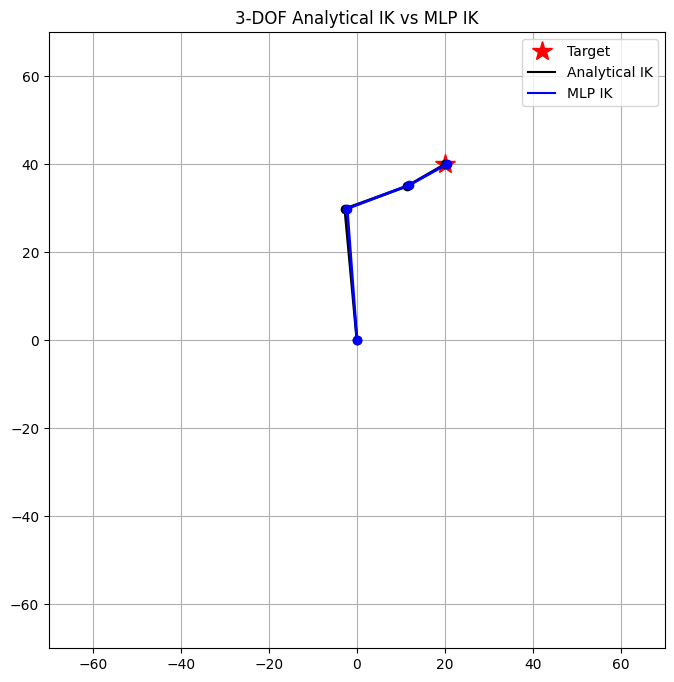


==================== RESULT ====================
Target (x,y,phi) = (20.00, 40.00, 30.00°)

Analytical FK EE: [20. 40.]
MLP FK EE      : [20.54277136 40.08843781]

End-effector Error (L2 norm) = 0.5499

Analytical IK (deg): [ 95.27266602 -75.28633029  10.01366428]
MLP IK (deg)       : [ 94.2585969  -73.45789433   8.17567483]


In [17]:
# ============================================================
# 15) Example: compare for one target
# ============================================================
compare_analytical_vs_mlp(target_x=20.0, target_y=40.0, target_phi_deg=30.0)